In [1]:
# Importar bibliotecas
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skopt import BayesSearchCV
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

#Estilizar conteúdo
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

# Importar a base de dados

df_eventos_2010_2017_modelo1 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo1.csv",
    sep=';',
    decimal=',',
)

estilo_tabelas(df_eventos_2010_2017_modelo1.head(5))

,Status,DH_total_danos_humanos,DM_total_danos_materiais,PEPL_total_publico,PEPR_total_privado,regiao_Centro-oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,Rendapercapita
0,0,4000,166542.286,6120428.994,7286224.972,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,17.934
1,0,8034,0.000,0.000,7639477.192,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.605
2,0,2732,0.000,0.000,26406.490,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,13.655
3,0,0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.997
4,0,0,2048392.375,2617.833,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.594


In [2]:
# Remover linhas com dados ausentes

df_eventos_2018_2024_modelo1 = df_eventos_2010_2017_modelo1.dropna()

estilo_tabelas(df_eventos_2010_2017_modelo1.head(5))

,Status,DH_total_danos_humanos,DM_total_danos_materiais,PEPL_total_publico,PEPR_total_privado,regiao_Centro-oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,Rendapercapita
0,0,4000,166542.286,6120428.994,7286224.972,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,17.934
1,0,8034,0.000,0.000,7639477.192,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.605
2,0,2732,0.000,0.000,26406.490,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,13.655
3,0,0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.997
4,0,0,2048392.375,2617.833,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.594


In [3]:
# Balanceamento da variável target

status_counts = df_eventos_2018_2024_modelo1['Status'].value_counts()
print("\nBalanceamento da variável 'Status':")
display(status_counts)


Balanceamento da variável 'Status':


Status
0    11814
1     1233
Name: count, dtype: int64

In [4]:
X_2010_2017_modelo1 = df_eventos_2010_2017_modelo1.drop('Status', axis=1)

y_2010_2017_modelo1 = df_eventos_2010_2017_modelo1['Status']

X_train_2010_2017_modelo1, X_test_2010_2017_modelo1, y_train_2010_2017_modelo1, y_test_2010_2017_modelo1 = train_test_split(X_2010_2017_modelo1, y_2010_2017_modelo1, test_size=0.2, random_state=1, stratify=y_2010_2017_modelo1)

In [5]:
# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],  # Taxa de aprendizado
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # Redução mínima da perda
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],  # Profundidade da árvore
    'xgb__min_child_weight': [1, 3, 5, 7],  # Peso mínimo para divisão do nó
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subamostragem para treinamento
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subamostragem de colunas
    'xgb__lambda': [0.01, 0.1, 1.0],  # Regularização L2
    'xgb__alpha': [0, 0.1, 0.5, 1.0]  # Regularização L1
}

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),  # Alterado para RobustScaler
    ('xgb', xgb.XGBClassifier(random_state=1, eval_metric='logloss'))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_xgb = BayesSearchCV(
    pipeline_xgb,
    search_spaces=param_grid_bayes,
    n_iter=30, 
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=1
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_xgb.fit(X_train_2010_2017_modelo1, y_train_2010_2017_modelo1)

# Melhor modelo encontrado
best_xgb_model = bayes_search_xgb.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_xgb.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_xgb = best_xgb_model.predict(X_test_2010_2017_modelo1)

# Relatório de classificação
classification_report_xgb = metrics.classification_report(y_test_2010_2017_modelo1, y_pred_xgb, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para XGBoost: \n')
print(classification_report_xgb)

Melhores hiperparâmetros: OrderedDict({'xgb__alpha': 0.1, 'xgb__colsample_bytree': 0.9, 'xgb__eta': 0.1, 'xgb__gamma': 1.0, 'xgb__lambda': 0.01, 'xgb__max_depth': 12, 'xgb__min_child_weight': 7, 'xgb__subsample': 0.8})
Classification report para XGBoost: 

                 precision    recall  f1-score   support

    Reconhecido   0.920267  0.991536  0.954573      2363
Não reconhecido   0.687500  0.178138  0.282958       247

       accuracy                       0.914559      2610
      macro avg   0.803884  0.584837  0.618766      2610
   weighted avg   0.898239  0.914559  0.891014      2610



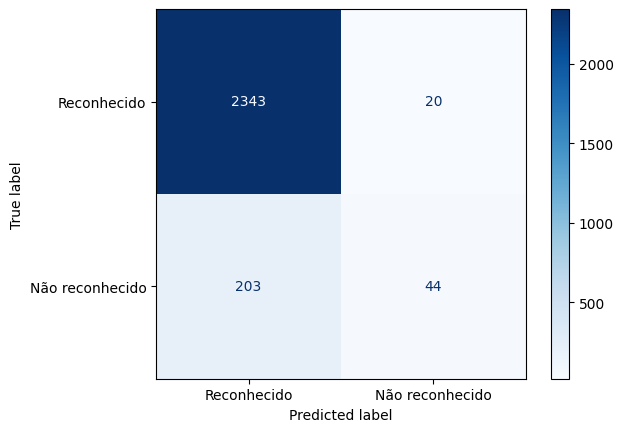

In [6]:
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test_2010_2017_modelo1, y_test_2010_2017_modelo1, values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

In [7]:
X_smote = df_eventos_2010_2017_modelo1.drop('Status', axis=1)

y_smote = df_eventos_2010_2017_modelo1['Status']

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1, stratify=y_smote)

In [8]:
# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__lambda': [0.01, 0.1, 1.0],
    'xgb__alpha': [0, 0.1, 0.5, 1.0]
}

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),  # Usando RobustScaler
    ('xgb', xgb.XGBClassifier(random_state=1, eval_metric='logloss'))
])

# Realizar a busca bayesiana com validação cruzada no conjunto balanceado pelo SMOTE
bayes_search_xgb = BayesSearchCV(
    pipeline_xgb,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=1
)

# Ajustar o modelo ao conjunto de treino balanceado
bayes_search_xgb.fit(X_train_smote, y_train_smote)

# Melhor modelo encontrado
best_xgb_model_smote = bayes_search_xgb.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros smote: {bayes_search_xgb.best_params_}")

# Fazer previsões com o conjunto de teste original
y_pred_xgb_smote = best_xgb_model_smote.predict(X_test_smote)

# Relatório de classificação
classification_report_xgb = metrics.classification_report(
    y_test_smote, y_pred_xgb_smote, digits=6, target_names=['Reconhecido', 'Não reconhecido']
)

print('Classification report para XGBoost com SMOTE: \n')
print(classification_report_xgb)

Melhores hiperparâmetros smote: OrderedDict({'xgb__alpha': 0, 'xgb__colsample_bytree': 0.8, 'xgb__eta': 0.025, 'xgb__gamma': 0.3, 'xgb__lambda': 0.01, 'xgb__max_depth': 25, 'xgb__min_child_weight': 1, 'xgb__subsample': 0.9})
Classification report para XGBoost com SMOTE: 

                 precision    recall  f1-score   support

    Reconhecido   0.926613  0.972493  0.948999      2363
Não reconhecido   0.500000  0.263158  0.344828       247

       accuracy                       0.905364      2610
      macro avg   0.713306  0.617825  0.646913      2610
   weighted avg   0.886240  0.905364  0.891822      2610



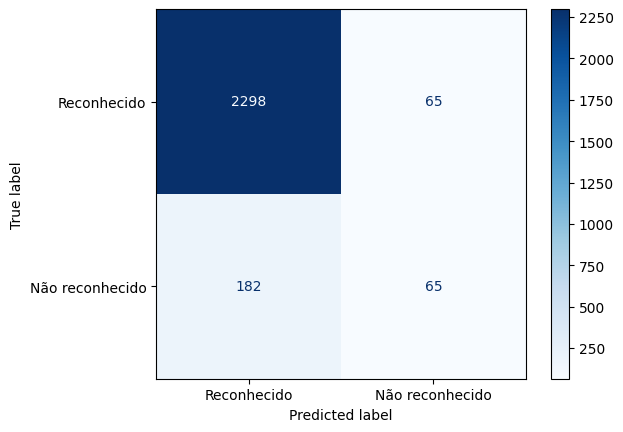

In [9]:
ConfusionMatrixDisplay.from_estimator(bayes_search_xgb, X_test_smote, y_test_smote, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

In [10]:
# Ajustar o melhor modelo encontrado (depois da busca bayesiana)
best_xgb_model.named_steps['xgb'].fit(X_train_2010_2017_modelo1, y_train_2010_2017_modelo1)

# Obter o booster (árvores) do modelo treinado
booster = best_xgb_model.named_steps['xgb'].get_booster()

# Obter a importância das features com base no ganho
importance_dict = booster.get_score(importance_type='gain')

# Transformar em DataFrame para organizar como tabela
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Ordenar pela importância em ordem decrescente
importance_df = importance_df.sort_values(by='Importance', ascending=False)

estilo_tabelas(importance_df)

,Feature,Importance
18,COBRADE_15110,25.514
5,regiao_Nordeste,9.271
8,regiao_Sul,6.883
14,COBRADE_13214,6.313
6,regiao_Norte,4.728
16,COBRADE_14110,4.476
7,regiao_Sudeste,4.442
1,DM_total_danos_materiais,4.364
17,COBRADE_14120,4.305
10,COBRADE_12100,4.162


C:\Users\Bruna\AppData\Local\Temp\ipykernel_24276\1183510742.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test_2010_2017_modelo1.columns[sorted_idx])


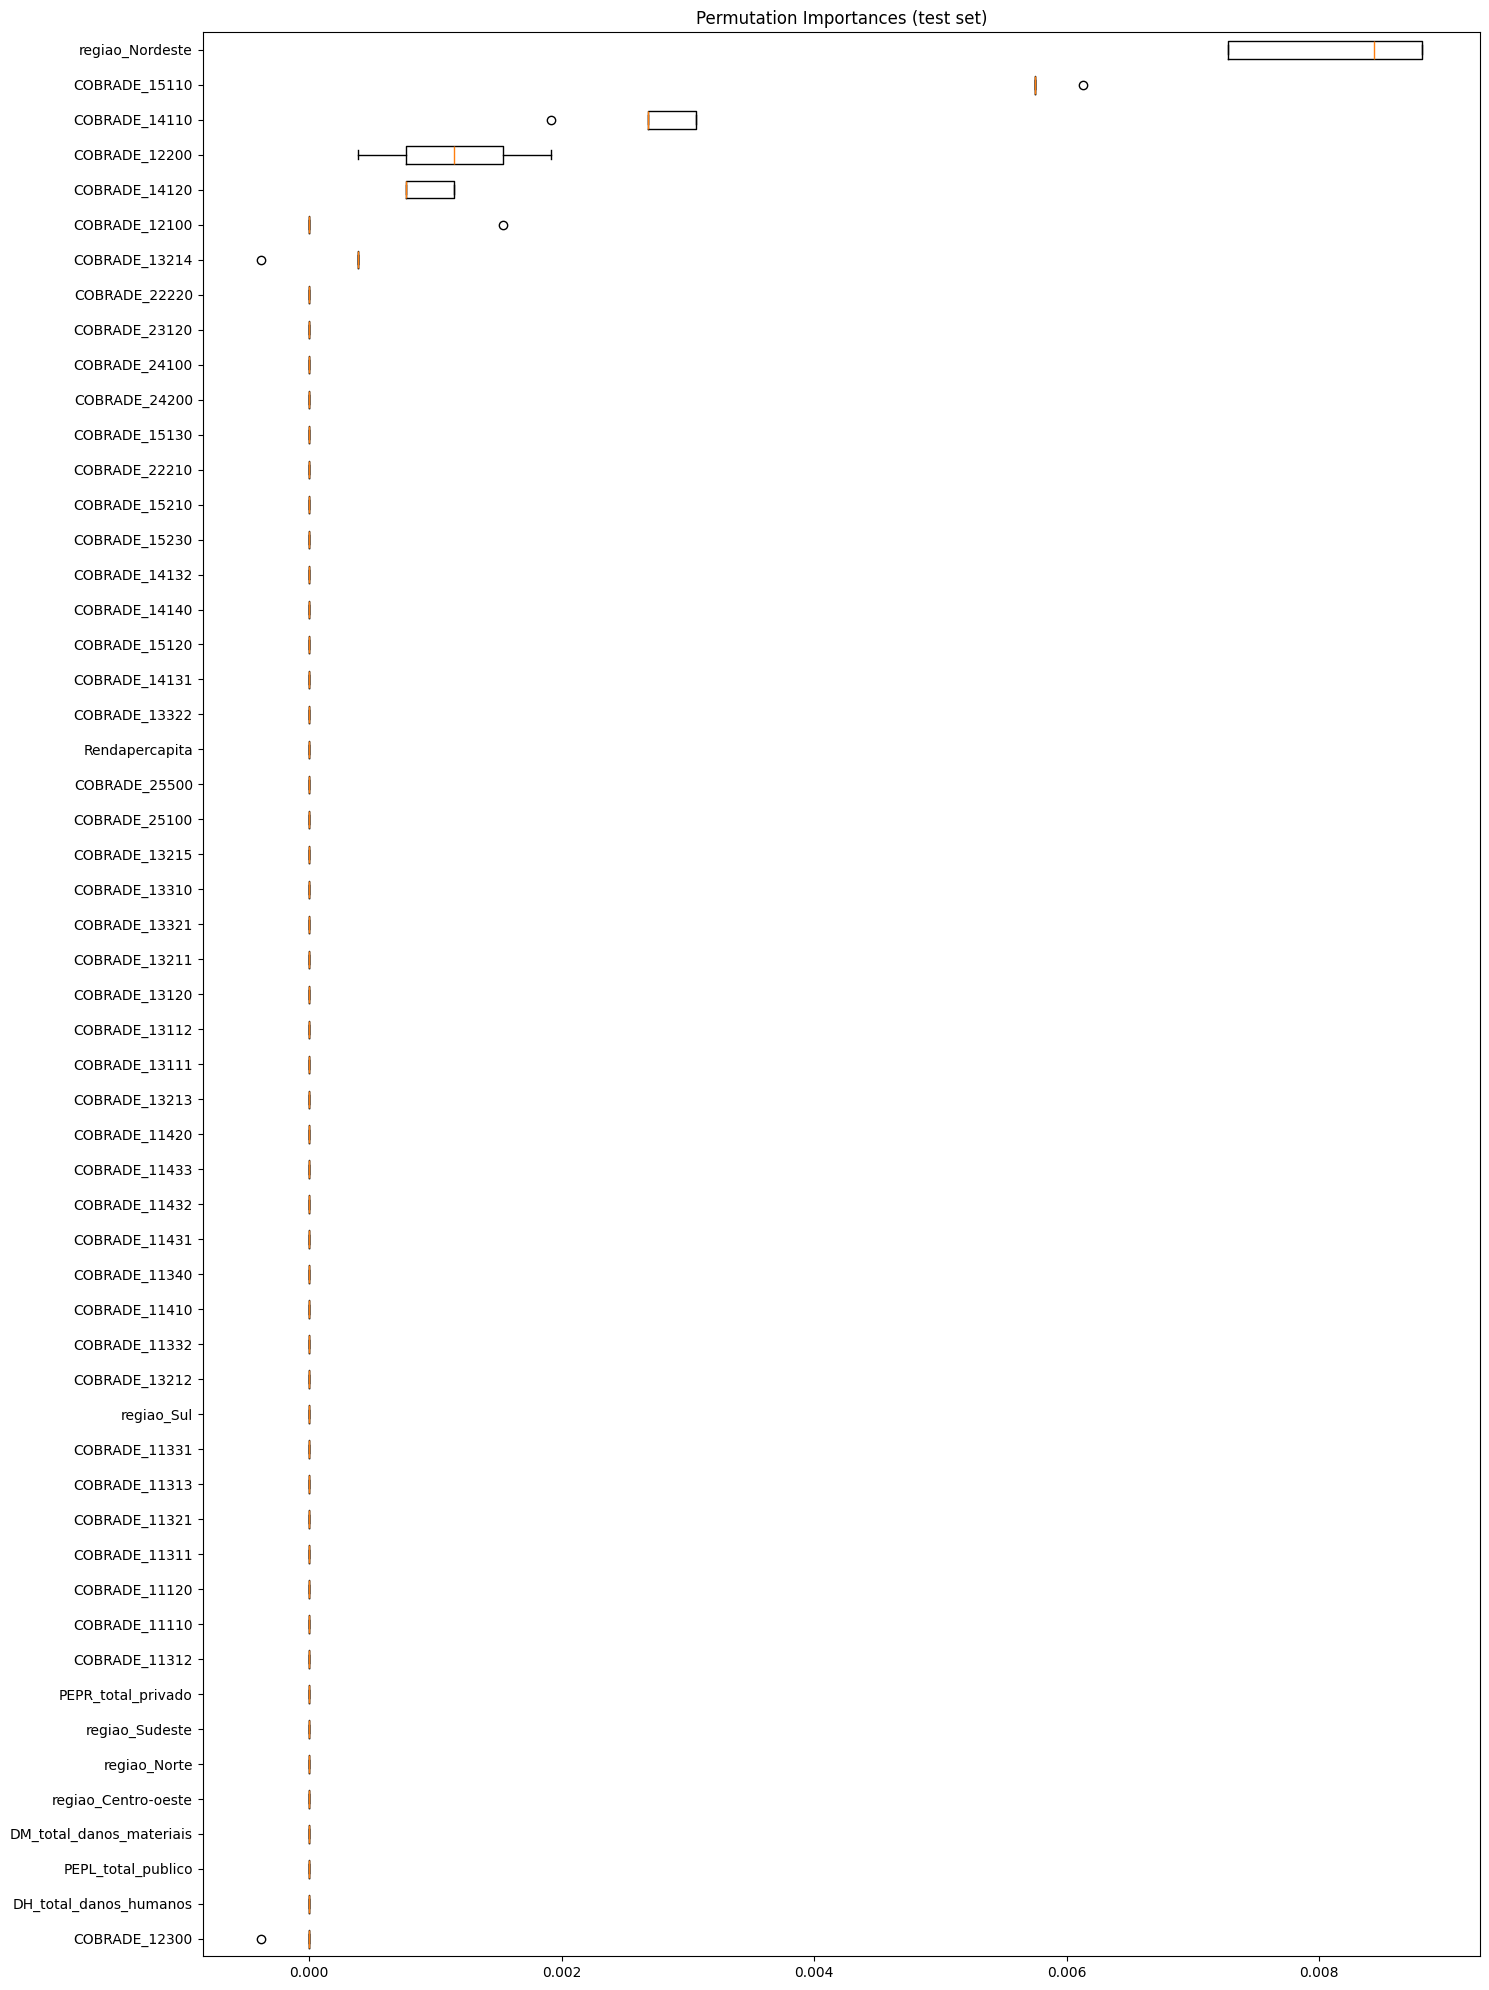

In [11]:
# Calcular a permutação de importância no conjunto de teste
result = permutation_importance(best_xgb_model, X_test_2010_2017_modelo1, y_test_2010_2017_modelo1, n_repeats=5, random_state=42, n_jobs=-1)

# Ordenar os resultados pela importância média
sorted_idx = result.importances_mean.argsort()

# Gráfico boxplot para mostrar a importância das variáveis
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test_2010_2017_modelo1.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.set_size_inches(15, 20) 
fig.tight_layout()
plt.show()